# Let's replace the nn model with a parameterised quantum circuit

In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd

# from data import harmonic_oscillator_solution
# from lossfn import mse, boundary_loss, physics_loss, physics_loss_imp
# from model import Hybrid_QN
# from utils import draw_circuit

import pennylane as qml

from IPython.display import clear_output

import copy

In [2]:
torch.manual_seed(123)
n_qubits = 6
n_layers = 5
n_input = 1
n_output = 1


# DATA USED

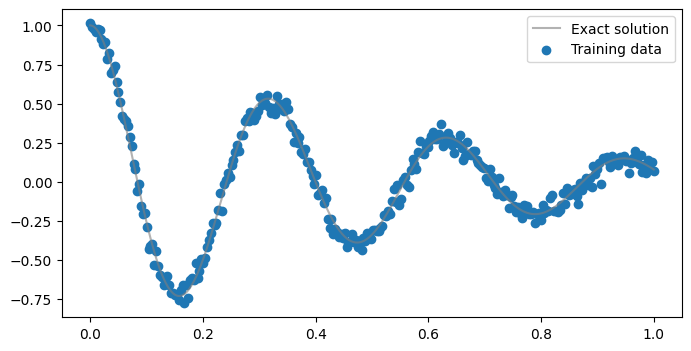

In [3]:
def harmonic_oscillator_solution(d, w0, t):

    ''' Analytical solution to a under-damped harmonic oscillator, I am just going to use the solution given above
    - d - delta, the damping ratio,
    - w0 - undamped angular frequency,
    - t - time,
    '''

    assert d < w0 # check for undamped case
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*t)
    exp = torch.exp(-d*t)
    x = exp*2*A*cos
    
    return x

# Full dataset
data = pd.read_csv('./time-oscillation.csv', dtype=np.float32)

d, w0 = 2, 20
t_true = torch.linspace(0,1,500).view(-1,1)
obs_true = harmonic_oscillator_solution(d, w0, t_true)

t_data = torch.tensor(data['t'].values).view(-1,1)
obs_data = torch.tensor(data['observation'].values).view(-1,1)

plt.figure(figsize=(8,4))
plt.plot(t_true, obs_true, color="tab:grey", alpha=0.6, label="Exact solution")
plt.scatter(t_data, obs_data, label="Training data")
plt.legend()
plt.show()

For simplicity, we only get 16% of data for training, as below:

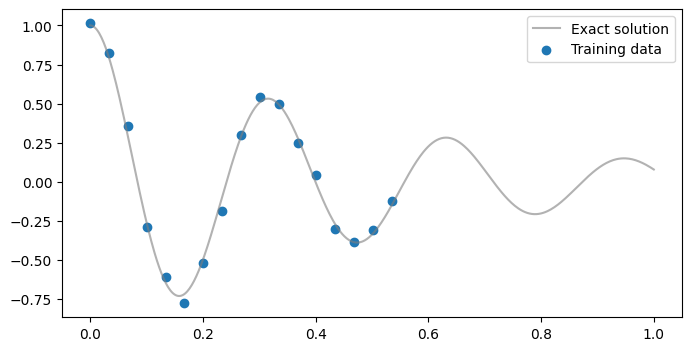

In [4]:
total = 100
percentage = 55

d, w0 = 2, 20
t_true = torch.linspace(0,1,500).view(-1,1)[:int(np.ceil(total/100*500))]
obs_true = harmonic_oscillator_solution(d, w0, t_true)

t_data = torch.tensor(data['t'].values)[:int(np.ceil(percentage/100*len(data)))][::10].view(-1,1)
obs_data = torch.tensor(data['observation'].values)[:int(np.ceil(percentage/100*len(data)))][::10].view(-1,1)

plt.figure(figsize=(8,4))
plt.plot(t_true, obs_true, color="tab:grey", alpha=0.6, label="Exact solution")
plt.scatter(t_data, obs_data, label="Training data")
plt.legend()
plt.show()

# Model and Loss functions

Please don't mind this lengthy code block

In [5]:
# Hybrid model and restriction on weights
class Hybrid_QN(nn.Module):
    '''
    Quantum layer -> Classical 1 layer
    '''

    def __init__(self, Q_DEVICE, INPUT_DIM:int, OUTPUT_DIM: int, N_QUBITS:int, N_LAYERS:int = 1, ROTATION:str = 'Ry'):
        super().__init__()

        self.wires = list(range(N_QUBITS))
        
        weight_shape = {
            'weights': self.quantum_circuit_shape(wires=N_QUBITS, n_layers=N_LAYERS, rot=ROTATION)
        }

        qc = self.quantum_circuit(wires = self.wires, rot=ROTATION)
        self.q_node = qml.QNode(qc, Q_DEVICE, expansion_strategy='gradient')


        self.input_layer= nn.Linear(INPUT_DIM, N_QUBITS)
        self.quantum_layer = qml.qnn.TorchLayer(self.q_node, weight_shape)
        # self.quantum_layer = nn.Linear(N_QUBITS, N_QUBITS)
        self.output_layer = nn.Linear(N_QUBITS, OUTPUT_DIM)

    def quantum_circuit_shape(self, wires, n_layers=1, rot='Ry'):
        if rot == 'Ry':
            shape = qml.BasicEntanglerLayers.shape(n_layers=n_layers, n_wires=wires)
        elif  rot == 'Rxyz':
            shape = qml.StronglyEntanglingLayers.shape(n_layers=n_layers, n_wires=wires)
        return shape

    def quantum_circuit(self, wires, rot='Ry'):
        def _quantum_circuit(inputs, weights): 
            # Prepare state H 
            [qml.Hadamard(i) for i in wires]

            # Encode classical -> quantum
            qml.AngleEmbedding(inputs, rotation='Y', wires=wires)

            # Process
            if rot == 'Ry':
                qml.BasicEntanglerLayers(weights, rotation=qml.RY, wires=wires)
            elif rot == 'Rxyz':
                qml.StronglyEntanglingLayers(weights, wires=wires)
            
            # Measurement quantum -> classical
            return [qml.expval(qml.PauliZ(wires=w)) for w in wires]
        return _quantum_circuit
    
    def draw_circuit(self, fontsize=20, style='pennylane', expansion_strategy='gradient', scale=None, title=None, decimals=2):

        data_in = torch.linspace(1,2, len(self.wires)) # Not real data, it is for visualise circuit only
        
        @torch.no_grad()
        def _draw_circuit(*args, **kwargs):
            nonlocal fontsize, style, expansion_strategy, scale, title
            qml.drawer.use_style(style)
            if expansion_strategy is None:
                expansion_strategy = self.q_node.expansion_strategy
            fig, ax = qml.draw_mpl(self.q_node, decimals=decimals, expansion_strategy=expansion_strategy)(*args, **kwargs)
            if scale is not None:
                dpi = fig.get_dpi()
                fig.set_dpi(dpi*scale)
            if title is not None:
                fig.suptitle(title, fontsize=fontsize)
            plt.show()
        _draw_circuit(data_in, self.quantum_layer.weights)

    def forward(self, x):
        x = self.input_layer(x)
        x = self.quantum_layer(x)
        x = self.output_layer(x)
        return x
    
# Apply this after every optimisation step
class WeightClipper(object):
    def __call__(self, module, param_range=[0, np.pi]):
        if hasattr(module, 'weights'):
            w = module.weights.data
            w = w.clamp(param_range[0], param_range[1])
            module.weights.data = w

def boundary_loss(prediction, t_boundary) -> torch.Tensor:
    ''' The **boundary loss**, tries to ensure that the solution learned by the PINN matches the initial conditions of the system.
    
    Returns the loss function for 2 initial conditions
    '''

    # minimising first condition that x(t=0) = 1 (see data notebook)
    loss1 = (torch.squeeze(prediction) - 1)**2

    dxdt = torch.autograd.grad(prediction, t_boundary, torch.ones_like(prediction), create_graph=True)[0]
    loss2 = (torch.squeeze(dxdt) - 0)**2

    return loss1, loss2

def physics_loss(prediction, t_physics, mu, k) -> torch.Tensor:
    ''' The **physics loss**, tries to ensure that the PINN solution obeys the underlying differential equation (see data notebook).
    
    Return the loss function for the harmonic oscillator DE 
    '''


    dxdt = torch.autograd.grad(prediction, t_physics, torch.ones_like(prediction), create_graph=True)[0]

    d2xdt2 = torch.autograd.grad(dxdt, t_physics, torch.ones_like(dxdt), create_graph=True)[0]
    loss = torch.mean((d2xdt2 + mu*dxdt + k*prediction)**2)

    return loss

def custom_weights(m): 
    torch.nn.init.uniform_(m.weights, 0, np.pi) 

def draw_circuit(circuit, fontsize=20, style='pennylane', expansion_strategy=None, scale=None, title=None, decimals=2):
    def _draw_circuit(*args, **kwargs):
        nonlocal circuit, fontsize, style, expansion_strategy, scale, title
        qml.drawer.use_style(style)
        if expansion_strategy is None:
            expansion_strategy = circuit.expansion_strategy
        fig, ax = qml.draw_mpl(circuit, decimals=decimals, expansion_strategy=expansion_strategy)(*args, **kwargs)
        if scale is not None:
            dpi = fig.get_dpi()
            fig.set_dpi(dpi*scale)
        if title is not None:
            fig.suptitle(title, fontsize=fontsize)
        plt.show()
    return _draw_circuit

In [6]:
dev = qml.device("default.qubit.torch", wires=n_qubits)

In [7]:
# qlayer.apply(custom_weights)
# qlayer.weights

In [8]:
# qmodel = FCN(N_INPUT=1, N_OUTPUT=1, N_HIDDEN=32, N_LAYERS=3)
qmodel = Hybrid_QN(Q_DEVICE=dev, INPUT_DIM=n_input, OUTPUT_DIM=n_output, N_QUBITS=n_qubits, N_LAYERS=n_layers, ROTATION='Rxyz')
# qmodel = Pure_QN(qlayer)

In [9]:
# qmodel.quantum_layer.apply(custom_weights)

# qmodel.quantum_layer.weights

In [10]:
# qmodel.draw_circuit(expansion_strategy='device')

In [11]:
# For initial condition loss
t_initial_grad = torch.tensor(0.).view(-1,1).requires_grad_(True)

t_data_grad = copy.deepcopy(t_data)
t_data_grad.requires_grad_(True)

t_true_grad = copy.deepcopy(t_true)
t_true_grad.requires_grad_(True)

d = 2
w0 = 20
mu = 2*d
k = w0**2

mu = torch.nn.Parameter(torch.zeros(1, requires_grad=True)) # mu is missing, let's train it!
all_mus = []
all_loss =[]

learning_rate=1e-2
optimiser = torch.optim.Adam(list(qmodel.parameters()) + [mu], lr=learning_rate)

# weighting the loss functions, see block below
lambda1, lambda2, lambda3, lambda4 = 1e5, 1e5, 1, 1e4

clipper = WeightClipper()
mseloss = nn.MSELoss()

In [12]:
list(qmodel.parameters())

[Parameter containing:
 tensor([[-0.4078],
         [ 0.0331],
         [-0.4967],
         [ 0.3771],
         [-0.8521],
         [ 0.7330]], requires_grad=True),
 Parameter containing:
 tensor([-0.7268, -0.7950, -0.6319,  0.4529, -0.3695,  0.3742],
        requires_grad=True),
 Parameter containing:
 tensor([[[0.4752, 1.2355, 1.9881],
          [2.5242, 0.7450, 5.1987],
          [2.4007, 4.1500, 5.3631],
          [3.7269, 4.0007, 6.1740],
          [1.7247, 4.1367, 1.7438],
          [5.3867, 5.6506, 0.2451]],
 
         [[5.8234, 4.6417, 4.5106],
          [4.4349, 5.7532, 2.7268],
          [0.4848, 2.2401, 0.9290],
          [3.3493, 2.5550, 1.4565],
          [2.8560, 6.1179, 2.8938],
          [3.2413, 2.6516, 3.6355]],
 
         [[5.9408, 5.0627, 4.2567],
          [3.8243, 3.8824, 4.3553],
          [2.7356, 0.2218, 1.1988],
          [5.8232, 3.3294, 0.5967],
          [3.6371, 5.7374, 0.1728],
          [1.0265, 1.8904, 3.2677]],
 
         [[2.4089, 2.7964, 0.0789],
   

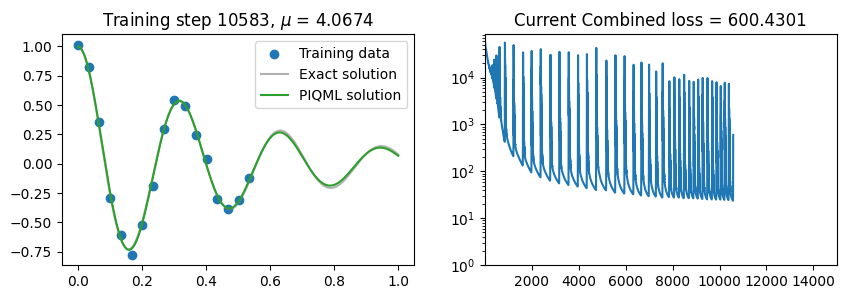


        Report on loss fns: 
        - Boundary Loss 1: 1.1332431313348934e-06
        - Boundary Loss 2: 0.005762606859207153
        - Physical Loss 1: 10.910271644592285
        - MSE: 0.0013145793927833438
        
[Parameter containing:
tensor([[-1.9325],
        [-3.5901],
        [-4.9380],
        [ 5.2897],
        [-3.9229],
        [ 5.5761]], requires_grad=True), Parameter containing:
tensor([-0.8503, -0.8149, -0.2480, -0.2498, -0.2171,  0.2593],
       requires_grad=True), Parameter containing:
tensor([[[6.0718e-04, 1.0583e+00, 2.4411e+00],
         [2.2693e+00, 8.8678e-01, 3.1012e+00],
         [2.4240e+00, 2.9045e+00, 2.7702e+00],
         [2.0569e+00, 3.1259e+00, 2.5231e+00],
         [1.5500e+00, 3.0764e+00, 1.9551e+00],
         [3.0446e+00, 3.1240e+00, 2.5699e-01]],

        [[3.1405e+00, 3.1375e+00, 2.7678e+00],
         [3.1232e+00, 3.1416e+00, 2.2850e+00],
         [6.6870e-01, 2.5338e+00, 5.2466e-01],
         [2.9699e+00, 3.0278e+00, 1.4000e+00],
         [2.66

In [13]:
for i in range(15000):
    optimiser.zero_grad()

    # Loss function for initial conditions
    prediction_initial = qmodel(t_initial_grad)
    loss1, loss2 = boundary_loss(prediction_initial, t_boundary=t_initial_grad)

    # Physics loss
    prediction_extend = qmodel(t_true_grad)
    loss3 = physics_loss(prediction_extend, t_physics=t_true_grad, mu=mu, k=k)

    # # Physics loss with dataset
    # loss3 = physics_loss(prediction, t_physics=t_data_grad, mu=mu, k=k)

    # Data loss
    prediction = qmodel(t_data_grad)
    loss4 = mseloss(prediction, obs_data)
    
    # Combined
    loss = lambda1*loss1 + lambda2*loss2 + lambda3*loss3 + lambda4*loss4
    
    if loss3 <= 10 and loss4 <= 0.002: break

    loss.backward()

    optimiser.step()

    qmodel.quantum_layer.apply(clipper)

    all_mus.append(mu.item())
    all_loss.append(loss.item())

    if i % 1 == 0: 
        clear_output(wait=True)
        prediction = qmodel(t_true).detach()
        # plt.figure(figsize=(8,2.5))

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,3))
        ax1.scatter(t_data, obs_data, label="Training data")
        ax1.plot(t_true[:,0], obs_true[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
        ax1.plot(t_true[:,0], prediction[:,0], label="PIQML solution", color="tab:green")
        ax1.legend()
        ax1.set_title(f"Training step {i+1}, $\mu$ = {np.around(mu.item(), 4)}")

        ax2.plot(all_loss)
        ax2.set_xlim(1,15001)
        ax2.set_ylim(1, all_loss[0])
        ax2.set_yscale('log', base=10)
        
        ax2.set_title(f"Current Combined loss = {np.around(loss.item(), 4)}")


        
        plt.savefig(f'./plots/PIQML_simple/i_{i}.png', dpi=400)
        plt.show()
        
        print(f'''
        Report on loss fns: 
        - Boundary Loss 1: {loss1}
        - Boundary Loss 2: {loss2}
        - Physical Loss 1: {loss3}
        - MSE: {loss4}
        ''')
        print(list(qmodel.parameters())) # Uncomment this to see parameters updating
    # Early stopping
    if loss3 <= 10 and loss4 <= 0.002: break


In [14]:
## MSE
np.mean((harmonic_oscillator_solution(d=2, w0=20, t=t_true) - qmodel(t_true)).detach().numpy())**2

1.2341217426059412e-06

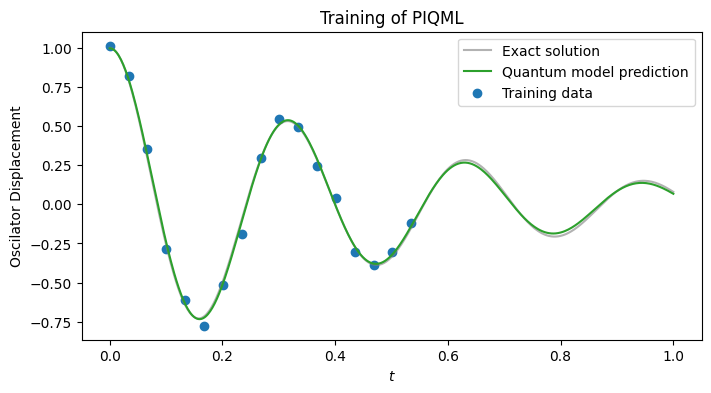

In [15]:
def plot_result(x,y,x_data,y_data,yh, title=None):

    plt.figure(figsize=(8,4))
    plt.title(title)
    plt.plot(x,y, color="tab:grey", alpha=0.6, label="Exact solution")
    plt.plot(x,yh, color="tab:green", label="Quantum model prediction")
    plt.scatter(x_data, y_data, label='Training data')
    plt.ylabel('Oscilator Displacement')
    plt.xlabel('$t$')
    l = plt.legend(loc='best')

plot_result(
    t_true.detach(),
    obs_true.detach(),
    t_data.detach(),
    obs_data.detach(),
    qmodel(t_true).detach(),
    title='Training of PIQML'
    )

mu = Parameter containing:
tensor([4.0674], requires_grad=True)


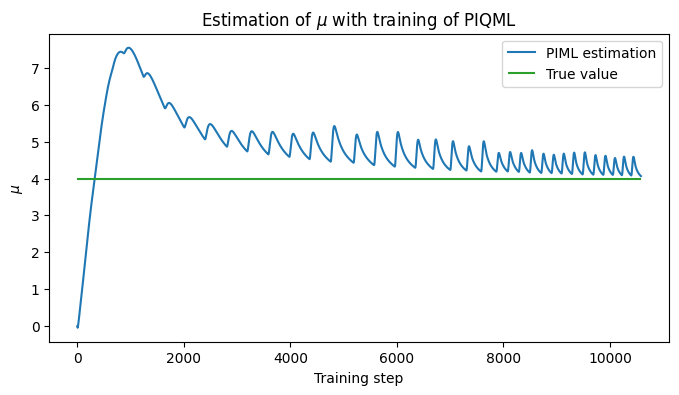

In [16]:
print(f'mu = {mu}')

plt.figure(figsize=(8,4))
plt.title("Estimation of $\mu$ with training of PIQML")
plt.plot(all_mus, label="PIML estimation")
plt.hlines(2*d, 0, len(all_mus), label="True value", color="tab:green")
plt.legend(loc='best')
plt.xlabel("Training step")
plt.ylabel("$\mu$")
plt.show()

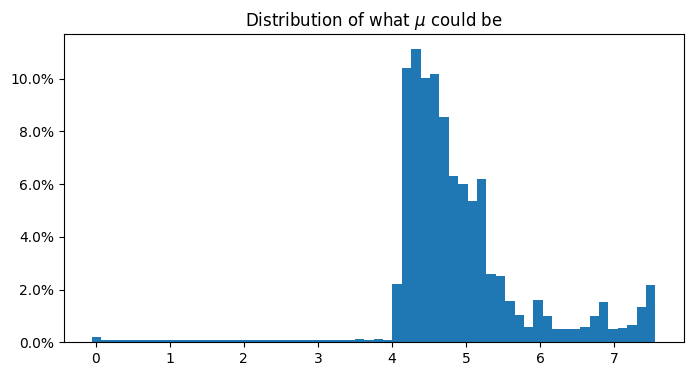

In [17]:
from matplotlib.ticker import PercentFormatter

plt.figure(figsize=(8,4))
plt.title('Distribution of what $\mu$ could be')
plt.hist(all_mus, bins=60, weights=np.ones(len(all_mus)) / len(all_mus))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()